In [14]:
import torch
import torch.nn as nn
import numpy as np
import base64


# Generator Code

In [2]:
class Generator(nn.Module):
    """
    Creates the Generator

    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nz: int = 64, ngf: int = 64):
        super(Generator, self).__init__()
        #self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [3]:
nz = 64;ngf = 64;nc = 3

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
netG = Generator(nz, ngf).to(device)

cpu


# LoadModel for deployment

In [4]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

In [5]:
netG.load_state_dict(torch.load('/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1420.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
with torch.no_grad():
    fake = netG(torch.randn(1, 64, 1, 1).to(device)).detach().cpu()
fakei = fake[0]
norm_tensor(fakei)

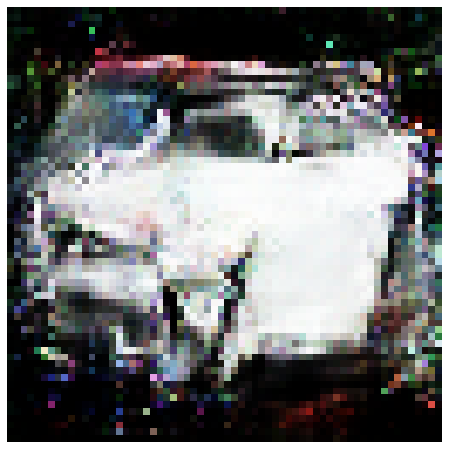

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(fakei.permute(1, 2, 0))
plt.axis('off')
plt.grid('off')

In [8]:
#traced_model = torch.jit.trace(netG.float(), torch.randn(1, 64, 1, 1).to(device))
#torch.jit.save(traced_model, '/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1420_tracedModel.pth')

In [35]:


t = fakei.numpy()
s = base64.b64encode(t)
img_str = f"data:image/jpeg;base64,{base64.b64encode(t).decode()}"
#r = base64.decodebytes(s)
#q = np.frombuffer(r, dtype=np.float64)

print(type(img_str))

<class 'str'>


In [9]:
from PIL import Image
import io
def img_to_base64(img):
    img = Image.fromarray(img, 'RGB') 
    buffer = io.BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()                     
    img_str = f"data:image/jpeg;base64,{base64.b64encode(myimage).decode()}"
    return img_str

def HWC_2_CHW(img):
    H, W, C = img.shape 
    im = np.zeros((C,H,W),dtype=np.float32)
    for i in range(C):
      im[i] = img[:,:,i]      
    return im

def img_normalize(img, means, stds):
    """
    Args:
        Numpy : Image of size (C, H, W) to be normalized.
    Returns:
        Numpy: Normalized image.
    """
    for i in range(3):
        img[i] = np.divide(np.subtract(img[i], means[i]), stds[i])
        img[i] = np.nan_to_num(img[i])
    return img

In [15]:
s6Img = fakei.numpy()
img_chw = HWC_2_CHW(s6Img)
img_chw = np.float32(img_chw)/255.0
means, stds = [0.5307, 0.5223, 0.5245], [0.2983, 0.2974, 0.2971]
img_chw = img_normalize(img_chw, means, stds)
img_chw = np.expand_dims(img_chw, axis=0) # Making batch size of 1

In [16]:
img_to_base64(s6Img)

''